
## Problem/Aim
Utilize historical data to <b>predict ride cost</b>. 

## Questions:
1. What is fare RMSE based on initial (limited features)?
2. How does feature engineering improve fare RMSE?
3. What is the best model for predicting fare?

## Hypotheses:
1. Distance traveled will scale in a postive and linear manner with fare_amount but demonstarte limited predictive power.
2. Including additional spatial and temporal features will improve predictions.
3. Random Forest Tree will improve predictions below $5.00 RMSE.


In [174]:
import os, sys
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import json
import geopandas as gpd
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy import stats
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import dask.dataframe as dd
from functools import partial
import multiprocessing
import datetime
from datetime import datetime
from dateutil.parser import parse
import code
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### 1) Pre-Process df

In [175]:
class pre_process (object):
    
    def __init__(self, *args, **kwargs):
        if 'chunk_size' in kwargs.keys():
            self.chunk_size = kwargs['chunk_size']
        else:
            self.chunk_size = None
        if 'df' in kwargs.keys():
            self.df_train = kwargs['df']
        else:
            self.df_train = pd.DataFrame()
    
    def data_chunk_ingest (self, *args, **kwargs):
        '''
        Ingest data in chunks. 
        '''
        try:
            chunk_list = []  # append each chunk df here 
        
            # Each chunk is in df format
            for chunk in pd.read_csv(os.getcwd() + '/equinox_case_study_train.csv', nrows = self.chunk_size):  

                # perform data filtering 
                chunk_filter = chunk_preprocessing(chunk)

                # Once the data filtering is done, append the chunk to list
                chunk_list.append(chunk_filter)

            # concat the list into dataframe 
            self.df_train = pd.concat(chunk_list).reset_index(drop = True)

            return self
        except Exception as e:
            print(e)
    
    def transform_datatype (self, *args, **kwargs):
        
        '''
        TRANSFORM DATA TYPE - REDUCE MEMORY ALLOCATION
        '''
        
        try:
            for i, t in zip(self.df_train.dtypes.reset_index().rename(columns = {'index': 'col', 0: 'dtype'})['col'], self.df_train.dtypes.reset_index().rename(columns = {'index': 'col', 0: 'dtype'})['dtype']):
                if t == 'float64':
                    self.df_train[i] = self.df_train[i].astype('float32')
                elif t == 'Int64':
                    self.df_train[i] = self.df_train[i].astype('Int32')
                elif t == 'object' and (isinstance(parse(self.df_train.at[0, i], fuzzy = False), datetime) == True):
                    self.df_train[i] = pd.to_datetime(self.df_train[i], utc = True)
                    self.df_train[i] = self.df_train[i].dt.tz_convert(kwargs['timezone'])
                else:
                    continue
            
            return self.df_train
        except Exception as e:
            print(e)

        

In [176]:
df_train = pd.read_csv(os.getcwd() + '/equinox_case_study_train.csv', nrows = 1000)

In [177]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,11.469940,-72.126972,39.732521,-72.198714,39.773237,1.592000
std,9.499792,11.555398,6.365536,11.327382,6.240137,1.222715
min,2.500000,-74.438233,0.000000,-74.185996,0.000000,0.000000
25%,6.000000,-73.993044,40.735310,-73.991830,40.732978,1.000000
50%,8.500000,-73.982135,40.752876,-73.980246,40.753924,1.000000
75%,13.000000,-73.966590,40.766689,-73.962534,40.767705,2.000000
max,66.300000,0.000000,40.993260,0.000000,40.881878,6.000000


In [178]:
#read in data
df_train = pd.read_csv(os.getcwd() + '/equinox_case_study_train.csv', nrows = 1000)

#pre-process data
df_train = pre_process(df = df_train).transform_datatype(timezone = 'US/Eastern')

#drop unecessary columns and null rows.
df_train = df_train.drop(columns = 'key').dropna().reset_index().rename(columns = {'index': 'id'})

# latitudes range from 0 to 90. 
# longitudes range from 0 to 180
df_train = df_train[
                    (df_train['pickup_latitude'] <= 180.00000) & 
                    (df_train['dropoff_latitude'] <= 180.00000) & 
                    (df_train['pickup_longitude'] >= -90.00000)
                ]

In [179]:
df_train.head()

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,4.5,2009-06-15 13:26:21-04:00,-73.844315,40.721317,-73.841614,40.712276,1
1,1,16.9,2010-01-05 11:52:16-05:00,-74.016045,40.711304,-73.979271,40.782005,1
2,2,5.7,2011-08-17 20:35:00-04:00,-73.982735,40.761269,-73.991241,40.750561,2
3,3,7.7,2012-04-21 00:30:42-04:00,-73.987129,40.733143,-73.991570,40.758091,1
4,4,5.3,2010-03-09 02:51:00-05:00,-73.968094,40.768009,-73.956657,40.783764,1


In [180]:
df_train.describe()

,id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,11.469939,-72.126968,39.732525,-72.198715,39.773239,1.592000
std,288.819436,9.499792,11.555399,6.365536,11.327382,6.240137,1.222715
min,0.000000,2.500000,-74.438232,0.000000,-74.185997,0.000000,0.000000
25%,249.750000,6.000000,-73.993042,40.735310,-73.991827,40.732977,1.000000
50%,499.500000,8.500000,-73.982136,40.752874,-73.980247,40.753925,1.000000
75%,749.250000,13.000000,-73.966591,40.766690,-73.962532,40.767706,2.000000
max,999.000000,66.300003,0.000000,40.993259,0.000000,40.881878,6.000000


### 2) Exploratory Data Analysis (EDA)

In [181]:
# Assess fare amount by # of passengers
df_train.groupby('passenger_count').agg({'passenger_count': 'count', 'fare_amount': 'mean'})

,passenger_count,fare_amount
passenger_count,,
0,3,15.133333
1,718,11.125404
2,151,13.130927
3,37,11.062973
4,16,11.268750
5,53,10.686792
6,22,13.531818


#### Outlier Detection/Visualization

Text(0.5, 1.0, 'Fare Amount by Passenger Count')

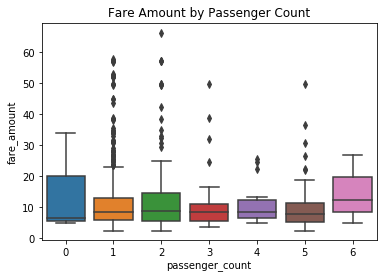

In [182]:
sns.boxplot(x = 'passenger_count', y = 'fare_amount', data = df_train).set_title('Fare Amount by Passenger Count')

Text(0, 0.5, 'Density')

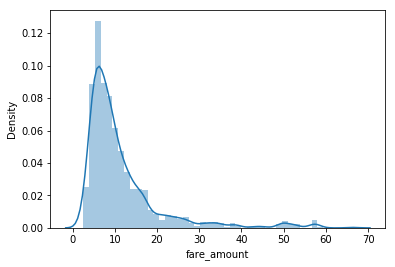

In [183]:
#visualize distribution
sns.distplot(df_train['fare_amount'], kde = True).set_ylabel('Density')

In [184]:
df_train['log_fare_amount'] = np.log10(df_train['fare_amount'])


Text(0, 0.5, 'Density')

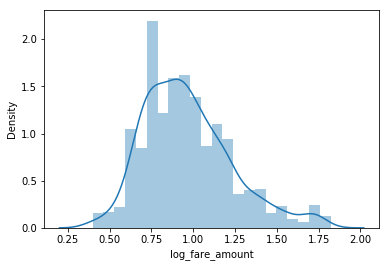

In [185]:
sns.distplot(df_train['log_fare_amount'], kde = True).set_ylabel('Density')

Text(0.5, 1.0, 'Log Fare Amount by Passenger Count')

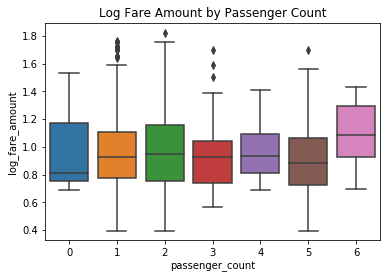

In [186]:
sns.boxplot(x = 'passenger_count', y = 'log_fare_amount', data = df_train).set_title('Log Fare Amount by Passenger Count')

Text(0, 0.5, 'Density')

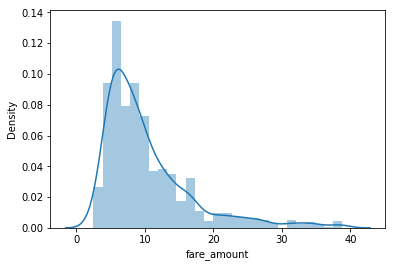

In [187]:
std_dev = 3
df = df_train[(np.abs(stats.zscore(df_train['fare_amount'])) < float(std_dev))]
sns.distplot(df['fare_amount'], kde = True).set_ylabel('Density')

Text(0.5, 1.0, 'Fare Amount by Passenger Count')

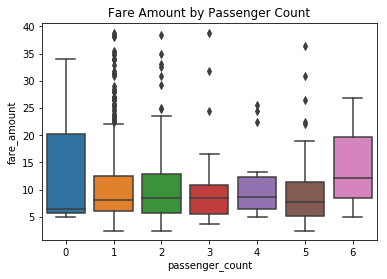

In [188]:
sns.boxplot(x = 'passenger_count', y = 'fare_amount', data = df).set_title('Fare Amount by Passenger Count')

#### 2a) spatial EDA

1. Distance between points
2. Crossing bridge?
3. location price changes. 

In [189]:
class spatial_features (object):
    
    def __init__(self, *args, **kwargs):
        with open ('nyc_county_polygon_layer.json') as f:
            self.nyc_county_shapefile = json.load(f)
        self.R = 6373.0
        if 'df' in kwargs.keys():
            self.df_train = kwargs['df']
        else:
            self.df_train = pd.DataFrame()
            
        self.nyc_airports = {
        
                'JFK':{
                        'min_lng': -73.8352,
                        'min_lat': 40.6195,
                        'max_lng': -73.7401, 
                        'max_lat': 40.6659
                    },

                'LGA':{
                        'min_lng': -73.8895, 
                        'min_lat': 40.7664, 
                        'max_lng': -73.8550, 
                        'max_lat': 40.7931    
                }
            }
            
        self.boro_map = {
        
                
                        'Bronx': 0,
                        'Brooklyn': 1,
                        'Manhattan': 2, 
                        'Staten Island': 3,
                        'Queens': 4

                }
        
    def pickup_location(self, *args, **kwargs):
        
        '''
        Add pickup count column
        '''
        try:
            self.df_train['pickup_county'] = None
            for idx, lat_p, lon_p in zip(self.df_train.index, self.df_train['pickup_longitude'], self.df_train['pickup_latitude']):
                point_pickup = Point (lat_p, lon_p)
                for feature in self.nyc_county_shapefile['features']:
                    county_polygon = shape(feature['geometry'])
                    if county_polygon.contains(point_pickup):
                        self.df_train.at[idx, 'pickup_county'] = feature['properties']['NAME']
                    else:
                        continue
            self.df_train['pickup_county_transform'] = self.df_train['pickup_county'].map(self.boro_map).astype('Int32')
            
            return self.df_train
        except Exception as e:
            print(e)
    
    def dropoff_location(self, *args, **kwargs):

        '''
        Add dropoff county column
        '''
        try:
            self.df_train['dropoff_county'] = None
            for idx, lat_d, lon_d in zip(self.df_train.index, self.df_train['dropoff_longitude'], self.df_train['dropoff_latitude']):
                point_dropoff = Point (lat_d, lon_d)
                for feature in self.nyc_county_shapefile['features']:
                    county_polygon = shape(feature['geometry'])
                    if county_polygon.contains(point_dropoff):
                        self.df_train.at[idx, 'dropoff_county'] = feature['properties']['NAME']
                    else:
                        continue
            self.df_train['dropoff_county_transform'] = self.df_train['dropoff_county'].map(self.boro_map).astype('Int32')
            
            return self.df_train
        except Exception as e:
            print(e)
    
    def haversine_distance(self, *args, **kwargs):
        
        '''
        Add Haversine distance column
        ''' 
        try:
            self.df_train['distance'] = None
            # approximate radius of earth in km
            for idx, lat_p, lon_p, lat_d, lon_d in zip(self.df_train.index, self.df_train['pickup_longitude'], self.df_train['pickup_latitude'], self.df_train['dropoff_longitude'], self.df_train['dropoff_latitude']):    
                dlon = radians(lon_d) - radians(lon_p)
                dlat = radians(lat_d) - radians(lat_p)
                a = sin(dlat / 2)**2 + cos(radians(lat_p)) * cos(radians(lat_d)) * sin(dlon / 2)**2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))
                self.df_train.at[idx, 'distance'] = self.R * c
            self.df_train['distance'] = self.df_train['distance'].astype(float) #distance in km
            self.df_train['distance'] = self.df_train['distance'] / 1.609344 # distance in mi
            self.df_train = self.df_train[self.df_train['distance'] < 1000.00].reset_index(drop = True)
            
            return self.df_train
        except Exception as e:
            print(e)
    
    def left_boro(self, *args, **kwargs):
            
        '''
        Add boro diff column
        '''
        try:
            self.df_train['left_boro'] = None
            for idx, pc, dc in zip(self.df_train.index, self.df_train['pickup_county'], self.df_train['dropoff_county']):
                if pc == dc:
                    self.df_train.at[idx, 'left_boro'] = 0
                else:               
                    self.df_train.at[idx, 'left_boro'] = 1
            self.df_train['left_boro'] = self.df_train['left_boro'].astype('Int32')
          
            return self.df_train
        except Exception as e:
            print(e)
            
    def airport(self, *args, **kwargs):
        
        '''
        Add airport column
        '''
        try:        
            self.df_train['pickup_airport'] = None
            self.df_train['dropoff_airport'] = None
            
            for airport in self.nyc_airports.keys():                
                for idx, lat_p, lon_p, lat_d, lon_d in zip(self.df_train.index, self.df_train['pickup_longitude'], self.df_train['pickup_latitude'], self.df_train['dropoff_longitude'], self.df_train['dropoff_latitude']):
                    if (lat_p >= self.nyc_airports[airport]['min_lat']) and (lat_p <= self.nyc_airports[airport]['max_lat']) and (lon_p >= self.nyc_airports[airport]['min_lng']) and (lon_p <= self.nyc_airports[airport]['max_lng']):
                        self.df_train.at[idx, 'pickup_airport'] = 1
                    elif (lat_d >= self.nyc_airports[airport]['min_lat']) and (lat_d <= self.nyc_airports[airport]['max_lat']) and (lon_d >= self.nyc_airports[airport]['min_lng']) and (lon_d <= self.nyc_airports[airport]['max_lng']):
                        self.df_train.at[idx, 'dropoff_airport'] = 1
                    else:
                        self.df_train.at[idx, 'pickup_airport'] = 0
                        self.df_train.at[idx, 'dropoff_airport'] = 0
            self.df_train['pickup_airport'] = self.df_train['pickup_airport'].astype('Int32')
            self.df_train['dropoff_airport'] = self.df_train['dropoff_airport'].astype('Int32')

            return self.df_train
        except Exception as e:
            print (e)
 

In [190]:
#run several spatial_feature functions
df_train = spatial_features(df = df_train).pickup_location()
df_train = spatial_features(df = df_train).dropoff_location()
df_train = spatial_features(df = df_train).haversine_distance()
df_train = spatial_features(df = df_train).left_boro()
df_train = spatial_features(df = df_train).airport()
df_train.head()

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,log_fare_amount,pickup_county,pickup_county_transform,dropoff_county,dropoff_county_transform,distance,left_boro,pickup_airport,dropoff_airport
0,0,4.5,2009-06-15 13:26:21-04:00,-73.844315,40.721317,-73.841614,40.712276,1,0.653212,Queens,4,Queens,4,0.255105,0,0,0
1,1,16.9,2010-01-05 11:52:16-05:00,-74.016045,40.711304,-73.979271,40.782005,1,1.227887,Manhattan,2,Manhattan,2,2.876541,0,0,0
2,2,5.7,2011-08-17 20:35:00-04:00,-73.982735,40.761269,-73.991241,40.750561,2,0.755875,Manhattan,2,Manhattan,2,0.622382,0,0,0
3,3,7.7,2012-04-21 00:30:42-04:00,-73.987129,40.733143,-73.991570,40.758091,1,0.886491,Manhattan,2,Manhattan,2,0.566008,0,0,0
4,4,5.3,2010-03-09 02:51:00-05:00,-73.968094,40.768009,-73.956657,40.783764,1,0.724276,Manhattan,2,Manhattan,2,0.845741,0,0,0


#### Visualize Pick-Ups and Drop-offs

In [191]:
#import shapefile ny state.
ny_state_county_shapefile = gpd.read_file('nyu_2451_34490/nyu_2451_34490.shp')

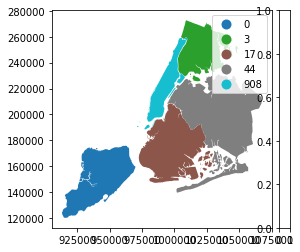

In [13]:
#plot pickups counts
df_train_pickup = df_train.groupby('pickup_county').count()['id'].reset_index()
ny_state_county_shapefile_pickup = ny_state_county_shapefile.merge(
                                                            df_train_pickup, how = 'left', left_on = 'bname', right_on = 'pickup_county'
                                                        )
ny_state_county_shapefile_pickup = ny_state_county_shapefile_pickup[
                                                        (ny_state_county_shapefile_pickup['bname'] == 'Bronx') |
                                                        (ny_state_county_shapefile_pickup['bname'] == 'Brooklyn') |
                                                        (ny_state_county_shapefile_pickup['bname'] == 'Manhattan') | 
                                                        (ny_state_county_shapefile_pickup['bname'] == 'Staten Island') |
                                                        (ny_state_county_shapefile_pickup['bname'] == 'Queens')]


ny_state_county_shapefile_pickup['id'] = ny_state_county_shapefile_pickup['id'].astype('Int64').fillna(0)
    

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.1)
ny_state_county_shapefile_pickup.plot(column = 'id', ax = ax, legend = True, cax = cax)


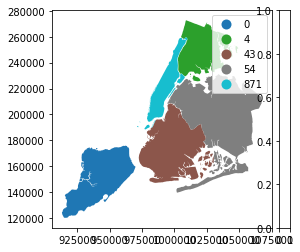

In [14]:
#plot pickups counts
df_train_dropoff = df_train.groupby('dropoff_county').count()['id'].reset_index()
ny_state_county_shapefile_dropoff = ny_state_county_shapefile.merge(
                                                            df_train_dropoff, how = 'left', left_on = 'bname', right_on = 'dropoff_county'
                                                        )
ny_state_county_shapefile_dropoff = ny_state_county_shapefile_dropoff[
                                                        (ny_state_county_shapefile_dropoff['bname'] == 'Bronx') |
                                                        (ny_state_county_shapefile_dropoff['bname'] == 'Brooklyn') |
                                                        (ny_state_county_shapefile_dropoff['bname'] == 'Manhattan') | 
                                                        (ny_state_county_shapefile_dropoff['bname'] == 'Staten Island') |
                                                        (ny_state_county_shapefile_dropoff['bname'] == 'Queens')]


ny_state_county_shapefile_dropoff['id'] = ny_state_county_shapefile_dropoff['id'].astype('Int64').fillna(0)
    

fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.1)
ny_state_county_shapefile_dropoff.plot(column = 'id', ax = ax, legend = True, cax = cax)


Text(0.5, 1.0, 'Log Fare Amount by Pickup County')

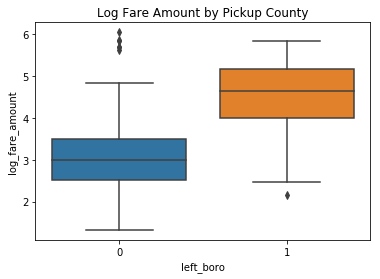

In [15]:
sns.boxplot(x = 'left_boro', y = 'log_fare_amount', data = df_train).set_title('Log Fare Amount by Pickup County')

Text(0.5, 1.0, 'Log Fare Amount by Pickup County')

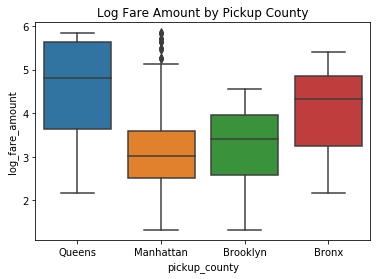

In [16]:
sns.boxplot(x = 'pickup_county', y = 'log_fare_amount', data = df_train).set_title('Log Fare Amount by Pickup County')

Text(0.5, 1.0, 'Log Fare Amount by Pickup County')

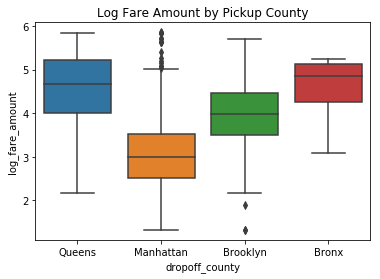

In [17]:
sns.boxplot(x = 'dropoff_county', y = 'log_fare_amount', data = df_train).set_title('Log Fare Amount by Pickup County')

Text(0.5, 1.0, 'Distance vs. Fare_Amount')

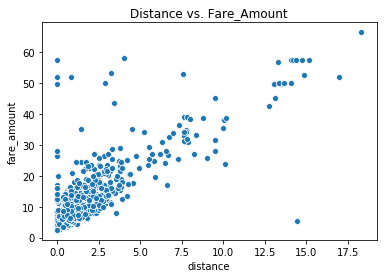

In [18]:
sns.scatterplot(x = 'distance', y = 'fare_amount', data = df_train).set_title('Distance vs. Fare_Amount')

#### 2b) Temporal EDA

1. Does price increase by date?

In [192]:
class temporal_features (object):
    
    def __init__(self, *args, **kwargs):

        if 'df' in kwargs.keys():
            self.df_train = kwargs['df']
        else:
            self.df_train = pd.DataFrame()
            
    def year_month_day_hour_transform (self, *args, **kwargs):
        try:
            self.df_train['unique_year'] = self.df_train['pickup_datetime'].dt.to_period('Y')
            self.df_train['year'] = df_train['pickup_datetime'].dt.year
            self.df_train['unique_month'] = self.df_train['pickup_datetime'].dt.to_period('M')
            self.df_train['month'] = self.df_train['pickup_datetime'].dt.month
            self.df_train['unique_day'] = self.df_train['pickup_datetime'].dt.to_period('D')
            self.df_train['day'] = self.df_train['pickup_datetime'].dt.day
            self.df_train['unique_hour'] = self.df_train['pickup_datetime'].dt.to_period('H')
            self.df_train['hour'] = self.df_train['pickup_datetime'].dt.hour

            return self.df_train
        except Exception as e:
            print(e)


In [193]:
df_train = temporal_features(df = df_train).year_month_day_hour_transform()
# df_train = pre_process(df = df_train).process_fare()
df_train.head()

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,log_fare_amount,pickup_county,...,pickup_airport,dropoff_airport,unique_year,year,unique_month,month,unique_day,day,unique_hour,hour
0,0,4.5,2009-06-15 13:26:21-04:00,-73.844315,40.721317,-73.841614,40.712276,1,0.653212,Queens,...,0,0,2009,2009,2009-06,6,2009-06-15,15,2009-06-15 13:00,13
1,1,16.9,2010-01-05 11:52:16-05:00,-74.016045,40.711304,-73.979271,40.782005,1,1.227887,Manhattan,...,0,0,2010,2010,2010-01,1,2010-01-05,5,2010-01-05 11:00,11
2,2,5.7,2011-08-17 20:35:00-04:00,-73.982735,40.761269,-73.991241,40.750561,2,0.755875,Manhattan,...,0,0,2011,2011,2011-08,8,2011-08-17,17,2011-08-17 20:00,20
3,3,7.7,2012-04-21 00:30:42-04:00,-73.987129,40.733143,-73.991570,40.758091,1,0.886491,Manhattan,...,0,0,2012,2012,2012-04,4,2012-04-21,21,2012-04-21 00:00,0
4,4,5.3,2010-03-09 02:51:00-05:00,-73.968094,40.768009,-73.956657,40.783764,1,0.724276,Manhattan,...,0,0,2010,2010,2010-03,3,2010-03-09,9,2010-03-09 02:00,2


In [21]:
a = df_train.groupby('hour').agg({'fare_amount': 'mean', 'log_fare_amount': 'mean','passenger_count': 'mean'})[['fare_amount', 'passenger_count']].reset_index()

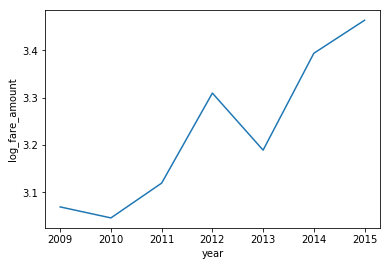

In [22]:
#fare by year
# df_train_year = df_train.set_index('pickup_datetime').groupby(pd.Grouper(freq = 'Y')).agg({'fare_amount': 'mean', 'passenger_count': 'sum'})[['fare_amount', 'passenger_count']].reset_index(drop = False)
df_train_year = df_train.groupby('year').agg({'fare_amount': 'mean', 'log_fare_amount': 'mean','passenger_count': 'mean'})[['fare_amount', 'log_fare_amount', 'passenger_count']].reset_index(drop = False)
sns.lineplot(x = "year", y = "log_fare_amount", data = df_train_year)

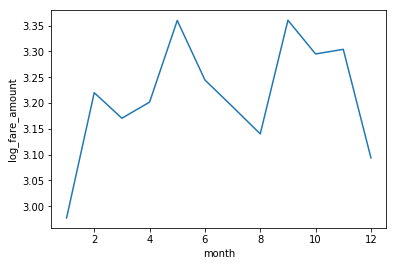

In [23]:
# df_train_month = df_train.set_index('pickup_datetime').groupby(pd.Grouper(freq = 'M')).agg({'fare_amount': 'mean', 'passenger_count': 'sum'})[['fare_amount', 'passenger_count']].reset_index(drop = False)
df_train_month = df_train.groupby('month').agg({'fare_amount': 'mean', 'log_fare_amount': 'mean','passenger_count': 'mean'})[['fare_amount', 'log_fare_amount', 'passenger_count']].reset_index(drop = False)
sns.lineplot(x = "month", y = "log_fare_amount", data = df_train_month)

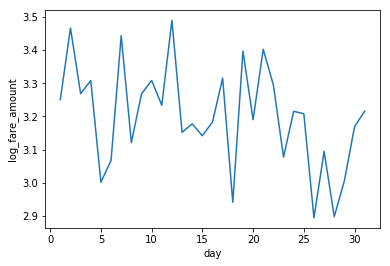

In [24]:
# df_train_day = df_train.set_index('pickup_datetime').groupby(pd.Grouper(freq = 'D')).agg({'fare_amount': 'mean', 'passenger_count': 'sum'})[['fare_amount', 'passenger_count']].reset_index(drop = False)
df_train_day = df_train.groupby('day').agg({'fare_amount': 'mean', 'log_fare_amount': 'mean','passenger_count': 'mean'})[['fare_amount', 'log_fare_amount', 'passenger_count']].reset_index(drop = False)
sns.lineplot(x = "day", y = "log_fare_amount", data = df_train_day)

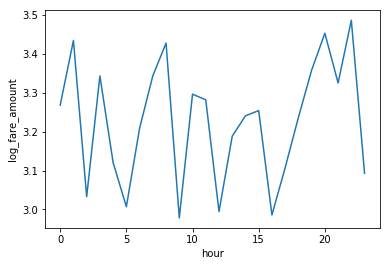

In [25]:
# df_train_hour = df_train.set_index('pickup_datetime').groupby(pd.Grouper(freq = 'H')).agg({'fare_amount': 'mean', 'passenger_count': 'sum'})[['fare_amount', 'passenger_count']].reset_index(drop = False)
df_train_hour = df_train.groupby('hour').agg({'fare_amount': 'mean', 'log_fare_amount': 'mean','passenger_count': 'mean'})[['fare_amount', 'log_fare_amount', 'passenger_count']].reset_index(drop = False)
sns.lineplot(x = "hour", y = "log_fare_amount", data = df_train_hour)

### Model Creation

We've now prepared a dataframe with several spatial and temporal features to be used as predictors for the target fare_amount. We will attempt to start simple with a simple linear regression and progress to more sophisticated machine learning algorithms. 

1. Simple Linear Regression
2. Regression Tree Regression
3. Random Forrest Regression

In [194]:
#read in data
df_test = pd.read_csv(os.getcwd() + '/equinox_case_study_test.csv', nrows = 1000)

#pre-process data
df_test = pre_process(df = df_test).transform_datatype(timezone = 'US/Eastern')

#drop unecessary columns and null rows.
df_test = df_test.drop(columns = 'key').dropna().reset_index().rename(columns = {'index': 'id'})

# latitudes range from 0 to 90. 
# longitudes range from 0 to 180
df_test = df_test[
                    (df_test['pickup_latitude'] <= 180.00000) & 
                    (df_test['dropoff_latitude'] <= 180.00000) & 
                    (df_test['pickup_longitude'] >= -90.00000)
                ]

df_test = spatial_features(df = df_test).pickup_location()
df_test = spatial_features(df = df_test).dropoff_location()
df_test = spatial_features(df = df_test).haversine_distance()
df_test = spatial_features(df = df_test).left_boro()
df_test = spatial_features(df = df_test).airport()
df_test = temporal_features(df = df_test).year_month_day_hour_transform()

In [203]:
# Linear Regression
X_train = pd.DataFrame(df_train['distance'])
y_train = pd.DataFrame(df_train['fare_amount'])

# model creation
model_lr = LinearRegression()
scores = []
rmse = []
r2 = []

kfold = KFold(n_splits = 3, shuffle = True, random_state = 42)
for i, (train, test) in enumerate(kfold.split(X_train, y_train)):
    model_lr.fit(X_train.iloc[train,:], y_train.iloc[train,:])
    scores.append(model_lr.score(X_train.iloc[test,:], y_train.iloc[test,:]))
    rmse.append(sqrt(mean_squared_error(X_train.iloc[test,:], y_train.iloc[test,:])))
    r2.append(r2_score(X_train.iloc[test,:], y_train.iloc[test,:]))
print('scores (rmse):', scores)
print('regression coefficient:', model_lr.coef_)

# print('r2:', r2)

# score = cross_val_score(model_lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kfold, n_jobs=1)
# print('score:', model_dt.score(X_train.iloc[test,:], y_train.iloc[test,:]))
# scores.append(model_lr.score(X_train.iloc[test,:], y_train.iloc[test,:]))
# print('-'*75)

print('avgroot mean score:', sqrt(abs(np.mean(scores))))

# Make predictions using the testing set
df_test = df_test.dropna()
model_lr = LinearRegression().fit(X_train, y_train)
df_test_y_pred = model_lr.predict(pd.DataFrame(df_test['distance']))
df_test['fare_amount'] = df_test_y_pred
# df_test['fare_amount'] = np.exp(df_test_y_pred) #transform from log scale pred.
df_test.loc[:10, ['distance', 'year', 'hour', 'day', 'fare_amount']]

scores (rmse): [0.6084946416129509, 0.8129461572383148, 0.6452506443170101]
regression coefficient: [[3.18859879]]
avgroot mean score: 0.8299982817589194


,distance,year,hour,day,fare_amount
0,7.857889,2009,17,15,31.798056
1,2.818116,2010,6,26,15.139137
2,1.141736,2011,3,5,9.597881
3,0.709107,2012,12,19,8.167830
4,13.002423,2010,12,15,48.803259
5,0.353007,2011,10,27,6.990747
6,2.650899,2012,4,14,14.586403
7,3.513837,2012,15,17,17.438835
8,0.390760,2012,10,17,7.115537
9,0.875856,2009,11,1,8.719018


In [201]:
# Regression Decision Tree
df_train = df_train.dropna()
X_train = pd.DataFrame(df_train[['distance', 'passenger_count', 'pickup_county_transform', 'dropoff_county_transform', 'left_boro', 'pickup_airport', 'dropoff_airport', 'year', 'month', 'day', 'hour']])
y_train = pd.DataFrame(df_train['fare_amount'])

scores = []
model_dt = DecisionTreeRegressor(max_depth = len(X_train.columns)-1, min_samples_split = 30, min_samples_leaf = 10, random_state = 0)
kfold = KFold(n_splits = 3, shuffle = True, random_state = 42)
for i, (train, test) in enumerate(kfold.split(X_train, y_train)):
    model_dt.fit(X_train.iloc[train,:], y_train.iloc[train,:])
    #Feature Importance
    feat_imp_dt = list(zip(X_train.iloc[train,:],  model_dt.fit(X_train.iloc[train,:], y_train.iloc[train,:]).feature_importances_))
    feat_imp_dt = pd.DataFrame(feat_imp_dt, columns=['Predictor', 'Importance Score']).sort_values(by = 'Importance Score', ascending = False)
    print(feat_imp_dt.reset_index(drop = True))
    score = cross_val_score(model_dt, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kfold, n_jobs=1)
    print('score:', model_dt.score(X_train.iloc[test,:], y_train.iloc[test,:]))
    scores.append(model_dt.score(X_train.iloc[test,:], y_train.iloc[test,:]))
    print('-'*75)

print('root mean score:', sqrt(abs(np.mean(scores))))


#Feature Importance
feat_imp_dt = list(zip(X_train, model_dt.fit(X_train, y_train).feature_importances_))
feat_imp_dt = pd.DataFrame(feat_imp_dt, columns=['Predictor', 'Importance Score']).sort_values(by = 'Importance Score', ascending = False)
print(feat_imp_dt.reset_index(drop = True))


# Make predictions using the testing set
df_test = df_test.dropna()
model_dt = DecisionTreeRegressor(max_depth = len(X_train.columns)-1, min_samples_split = 30, min_samples_leaf = 10, random_state = 0).fit(X_train, y_train)
df_test_y_pred = model_dt.predict(pd.DataFrame(df_test[['distance', 'passenger_count', 'pickup_county_transform', 'dropoff_county_transform', 'left_boro', 'pickup_airport', 'dropoff_airport', 'year', 'month', 'day', 'hour']]))
df_test['fare_amount'] = df_test_y_pred
# df_test['fare_amount'] = np.exp(df_test_y_pred) #transform from log scale pred.
df_test.loc[:10, ['distance', 'left_boro', 'year', 'hour', 'day', 'fare_amount']]

                   Predictor  Importance Score
0                   distance          0.952390
1                       year          0.019809
2                       hour          0.016777
3                        day          0.008497
4                      month          0.002527
5            passenger_count          0.000000
6    pickup_county_transform          0.000000
7   dropoff_county_transform          0.000000
8                  left_boro          0.000000
9             pickup_airport          0.000000
10           dropoff_airport          0.000000
score: 0.5982025611021793
---------------------------------------------------------------------------
                   Predictor  Importance Score
0                   distance          0.960850
1                       year          0.012960
2                        day          0.012726
3                      month          0.010489
4            passenger_count          0.001603
5                       hour          0.001373
6    

,distance,left_boro,year,hour,day,fare_amount
0,7.857889,1,2009,17,15,34.072857
1,2.818116,0,2010,6,26,15.420000
2,1.141736,0,2011,3,5,19.940000
3,0.709107,0,2012,12,19,5.130000
4,13.002423,1,2010,12,15,49.393889
5,0.353007,0,2011,10,27,5.400000
6,2.650899,0,2012,4,14,13.471429
7,3.513837,0,2012,15,17,22.819630
8,0.390760,0,2012,10,17,5.315789
9,0.875856,0,2009,11,1,6.588000


In [197]:
from sklearn.tree import export_graphviz
import graphviz
export_graphviz(model_dt, out_file ='tree.png', feature_names = ['distance', 'passenger_count', 'left_boro', 'pickup_airport', 'dropoff_airport', 'year', 'month', 'day', 'hour'])

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

ValueError: Length of feature_names, 9 does not match number of features, 11

In [198]:
# Regression Random Forest
df_train = df_train.dropna()
X_train = pd.DataFrame(df_train[['distance', 'passenger_count', 'pickup_county_transform', 'dropoff_county_transform', 'left_boro', 'pickup_airport', 'dropoff_airport', 'year', 'month', 'day', 'hour']])
y_train = pd.DataFrame(df_train['fare_amount'])

scores = []
model_rf = RandomForestRegressor(bootstrap = True, n_estimators = 100)
kfold = KFold(n_splits = 3, shuffle = True, random_state = 42)
for i, (train, test) in enumerate(kfold.split(X_train, y_train)):
    model_rf.fit(X_train.iloc[train,:], y_train.iloc[train,:])
    #Feature Importance
    feat_imp_rf = list(zip(X_train.iloc[train,:],  model_rf.fit(X_train.iloc[train,:], y_train.iloc[train,:]).feature_importances_))
    feat_imp_rf = pd.DataFrame(feat_imp_rf, columns=['Predictor', 'Importance Score']).sort_values(by = 'Importance Score', ascending = False)
    print(feat_imp_rf.reset_index(drop = True))
    score = cross_val_score(model_rf, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kfold, n_jobs=1)
    print('score:', model_rf.score(X_train.iloc[test,:], y_train.iloc[test,:]))
    scores.append(model_rf.score(X_train.iloc[test,:], y_train.iloc[test,:]))
    print('-'*75)

print('avg_rmse:', sqrt(abs(np.mean(scores))))

#Feature Importance
feat_imp_rf = list(zip(X_train, model_rf.fit(X_train, y_train).feature_importances_))
feat_imp_rf = pd.DataFrame(feat_imp_rf, columns=['Predictor', 'Importance Score']).sort_values(by = 'Importance Score', ascending = False)
print(feat_imp_rf.reset_index(drop = True))


# Make predictions using the testing set
df_test = df_test.dropna()
model_rf = RandomForestRegressor(bootstrap = True, n_estimators = 100).fit(X_train, y_train)
df_test_y_pred = model_rf.predict(pd.DataFrame(df_test[['distance', 'passenger_count', 'pickup_county_transform', 'dropoff_county_transform', 'left_boro', 'pickup_airport', 'dropoff_airport', 'year', 'month', 'day', 'hour']]))
df_test['fare_amount'] = df_test_y_pred
# df_test['fare_amount'] = np.exp(df_test_y_pred) #transform from log scale pred.
df_test.loc[:10, ['distance', 'left_boro', 'year', 'hour', 'day', 'fare_amount']]


                   Predictor  Importance Score
0                   distance          0.824498
1                        day          0.037253
2                       year          0.035560
3                       hour          0.028792
4                      month          0.024184
5            passenger_count          0.017766
6    pickup_county_transform          0.014015
7   dropoff_county_transform          0.010949
8                  left_boro          0.006983
9             pickup_airport          0.000000
10           dropoff_airport          0.000000
score: 0.6658840628183016
---------------------------------------------------------------------------
                   Predictor  Importance Score
0                   distance          0.780378
1                      month          0.039847
2                       hour          0.037127
3                       year          0.035274
4                        day          0.031971
5    pickup_county_transform          0.028146
6   d

,distance,left_boro,year,hour,day,fare_amount
0,7.857889,1,2009,17,15,32.0412
1,2.818116,0,2010,6,26,14.8216
2,1.141736,0,2011,3,5,13.5716
3,0.709107,0,2012,12,19,6.4540
4,13.002423,1,2010,12,15,49.1463
5,0.353007,0,2011,10,27,5.8580
6,2.650899,0,2012,4,14,15.3990
7,3.513837,0,2012,15,17,21.3913
8,0.390760,0,2012,10,17,7.2330
9,0.875856,0,2009,11,1,7.9320


In [54]:
#Create a grid for tuning parameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [56]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [57]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

In [202]:
# Regression Random Forest
df_train = df_train.dropna()
X_train = pd.DataFrame(df_train[['distance', 'passenger_count', 'pickup_county_transform', 'dropoff_county_transform', 'left_boro', 'pickup_airport', 'dropoff_airport', 'year', 'month', 'day', 'hour']])
y_train = pd.DataFrame(df_train['fare_amount'])

scores = []
model_rf = RandomForestRegressor(bootstrap = True, n_estimators = 400, max_depth = 70, max_features = 'auto', min_samples_leaf = 4, min_samples_split = 10)
kfold = KFold(n_splits = 3, shuffle = True, random_state = 42)
for i, (train, test) in enumerate(kfold.split(X_train, y_train)):
    model_rf.fit(X_train.iloc[train,:], y_train.iloc[train,:])
    #Feature Importance
    feat_imp_rf = list(zip(X_train.iloc[train,:],  model_rf.fit(X_train.iloc[train,:], y_train.iloc[train,:]).feature_importances_))
    feat_imp_rf = pd.DataFrame(feat_imp_rf, columns=['Predictor', 'Importance Score']).sort_values(by = 'Importance Score', ascending = False)
    print(feat_imp_rf.reset_index(drop = True))
    score = cross_val_score(model_rf, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kfold, n_jobs=1)
    print('score:', model_rf.score(X_train.iloc[test,:], y_train.iloc[test,:]))
    scores.append(model_rf.score(X_train.iloc[test,:], y_train.iloc[test,:]))
    print('-'*75)

print('root mean score:', sqrt(abs(np.mean(scores))))

#Feature Importance
feat_imp_rf = list(zip(X_train, model_rf.fit(X_train, y_train).feature_importances_))
feat_imp_rf = pd.DataFrame(feat_imp_rf, columns=['Predictor', 'Importance Score']).sort_values(by = 'Importance Score', ascending = False)
print(feat_imp_rf.reset_index(drop = True))

# Make predictions using the testing set
df_test = df_test.dropna()
model_rf = RandomForestRegressor(bootstrap = True, n_estimators = 100).fit(X_train, y_train)
df_test_y_pred = model_rf.predict(pd.DataFrame(df_test[['distance', 'passenger_count', 'pickup_county_transform', 'dropoff_county_transform', 'left_boro', 'pickup_airport', 'dropoff_airport', 'year', 'month', 'day', 'hour']]))
df_test['fare_amount'] = df_test_y_pred
# df_test['fare_amount'] = np.exp(df_test_y_pred) #transform from log scale pred.
df_test.loc[:10, ['distance', 'left_boro', 'year', 'hour', 'day', 'fare_amount']]

                   Predictor  Importance Score
0                   distance          0.905353
1                       year          0.028410
2                       hour          0.016598
3                        day          0.015077
4                      month          0.011087
5   dropoff_county_transform          0.010964
6                  left_boro          0.006438
7    pickup_county_transform          0.003555
8            passenger_count          0.002519
9             pickup_airport          0.000000
10           dropoff_airport          0.000000
score: 0.6506736566996761
---------------------------------------------------------------------------
                   Predictor  Importance Score
0                   distance          0.867794
1                       year          0.025399
2   dropoff_county_transform          0.024905
3                      month          0.021040
4                       hour          0.021005
5                        day          0.018073
6    

,distance,left_boro,year,hour,day,fare_amount
0,7.857889,1,2009,17,15,32.4050
1,2.818116,0,2010,6,26,14.8170
2,1.141736,0,2011,3,5,11.9995
3,0.709107,0,2012,12,19,6.4330
4,13.002423,1,2010,12,15,48.8160
5,0.353007,0,2011,10,27,6.1790
6,2.650899,0,2012,4,14,15.4940
7,3.513837,0,2012,15,17,20.2920
8,0.390760,0,2012,10,17,7.4400
9,0.875856,0,2009,11,1,8.3480


In [119]:
output = df_test.loc[:, ['pickup_datetime'`, 'fare_amount']]
df_test.to_csv('output.csv')

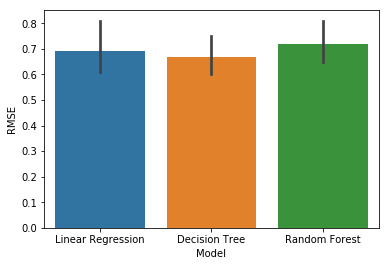

In [207]:
gra = pd.DataFrame({'Model' : ['Linear Regression', 'Decision Tree', 'Random Forest', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Linear Regression', 'Decision Tree', 'Random Forest'], 'RMSE': [0.61, 0.60, 0.65, 0.81, 0.75, 0.81, 0.65, 0.66, 0.70]})

sns.barplot(x = 'Model', y = 'RMSE', data = gra)


In [172]:
import seaborn as sns
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## Final Conclusions

The ability to predidct taxi fare is a valuable feature for consumers in the current ride for hire market. By engineering features and tuning parameters a Random Forest learner was able to predict fare_amount with a RMSE of $4.92.

Hypothesis 1 is accepted due to the linear relationship between fare_amount and distance travelled. However, distance alone shoes an average rmse of $12.20. Hypothesis 2 is accepted (null rejected) as additional features improved the model. Hypothesis 3 is accepted as a Random Forest demonstrated the lowest error. 

Future improvements would include capturing dropoff_datetime. This information would allow for several additional features such as ride_time, average_speed both of which have fare implications according to https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page.

